# Data preparation/exploration for the Aguathon

## Problem definition

Find the best model that predict the level of the Evro river when cros Zaragoza.

----

## Index

1. [Import modules and Data](#first-bullet)
2. [Data exploration](#second-bullet)
3. [Feature Engineering](#third-bullet)
4. [Missing Values](#fourth-bullet)
   * Split the data in train and test set
5. [Model regressor](#fifth-bullet)
    * Cross-validation

## Import modules and Data <a class="anchor" id="first-bullet"></a>

In [1]:
%load_ext autoreload
%matplotlib inline
#%matplotlib notebook
%autoreload 1


# STD lib imports
import os
import sys

# Third party libs
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# sklear stuff
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

# root path of the project
PROJ_ROOT = os.path.join(os.pardir)

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.make_dataset
%aimport features.build_features
import data.make_dataset as md
import features.build_features as bf

os.environ['KMP_DUPLICATE_LIB_OK']='True'

print(os.path.abspath(PROJ_ROOT))

# Load data from ITA
raw_file = 'datos.csv'
path = '../ENTRADA/'
df_raw = md.load_data(path, raw_file)

# period of the data
start = df_raw.index.min()
end = df_raw.index.max()

idx = df_raw.resample('D').mean().index
print('Shape:', df_raw.shape)
display(df_raw.tail())

/Users/miloc/Documents/git-hub/Apsu
Shape: (95856, 10)


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,pred_24h,pred_48h,pred_72h
time,,,,,,,,,,
2018-12-07 19:00:00,0.9850,0.6950,1.7300,0.52,0.8450,1.05,False,1.03,1.0,0.99
2018-12-07 20:00:00,0.9800,0.6925,1.7475,0.52,0.8450,1.05,False,1.03,1.0,0.99
2018-12-07 21:00:00,0.9675,0.6925,1.7500,0.52,0.8375,1.05,False,1.03,1.0,0.99
2018-12-07 22:00:00,0.9550,0.6925,1.7400,0.52,0.8300,1.05,False,1.03,1.0,0.99
2018-12-07 23:00:00,0.9450,0.6925,1.7375,0.52,0.8300,1.05,False,1.03,1.0,0.99


In [2]:
# Estation to load data
estaciones = {'pna': '9262-19530901-20190131.csv',  
              'zar_aero':'9434-19410101-20190302.csv'} 

# inputs
cols = ['FECHA','TMEDIA','TMIN','TMAX','PRECIPITACION']
path_meteo = '../data/DatosPorEstacion2019-03-02/DatosPorEstacion/'

# Load meteo data and filter by period
df_meteo = md.load_meteo(path_meteo, estaciones, cols) 
    
# complete hourly data
df_meteo = df_meteo.resample('H').ffill()/24

# Filter by period
df_meteo = df_meteo[(df_meteo.index >= start) & (df_meteo.index <= end)]

print('Shape:', df_meteo.shape)
display(df_meteo.tail())

Shape: (95856, 8)


,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
FECHA,,,,,,,,
2018-12-07 19:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


In [3]:
# Concatenate both data frames
df = pd.concat([df_raw, df_meteo], axis=1)

print('Shape:', df.shape)
display(df.tail())

Shape: (95856, 18)


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,pred_24h,pred_48h,pred_72h,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
2018-12-07 19:00:00,0.9850,0.6950,1.7300,0.52,0.8450,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,0.9800,0.6925,1.7475,0.52,0.8450,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,0.9675,0.6925,1.7500,0.52,0.8375,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,0.9550,0.6925,1.7400,0.52,0.8300,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,0.9450,0.6925,1.7375,0.52,0.8300,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


In [4]:
df.isnull().sum()

ALAGON_NR                 16968
GRISEN_NR                  8710
NOVILLAS_NR                1468
TAUSTE_NR                   519
TUDELA_NR                   277
ZGZ_NR                        0
RIESGO                        0
pred_24h                      0
pred_48h                      0
pred_72h                      0
TMEDIA_pna                   48
TMIN_pna                     24
TMAX_pna                     24
PRECIPITACION_pna            24
TMEDIA_zar_aero               0
TMIN_zar_aero                 0
TMAX_zar_aero                 0
PRECIPITACION_zar_aero        0
dtype: int64

## Data exploration <a class="anchor" id="second-bullet"></a>

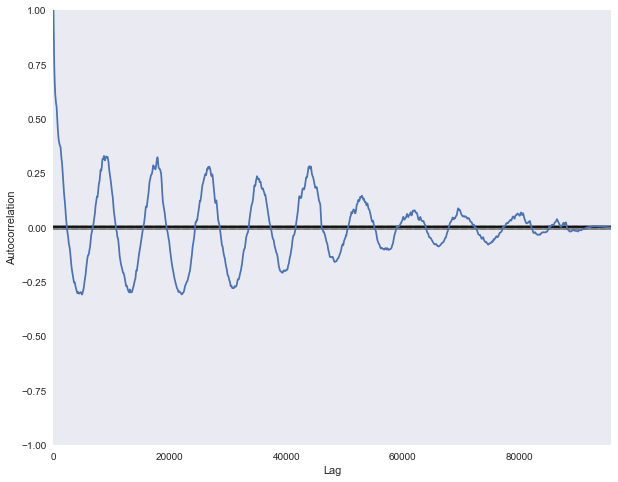

In [5]:
plt.figure(figsize=(10,8))
pd.plotting.autocorrelation_plot(df.ZGZ_NR)

## Feature engineering <a class="anchor" id="third-bullet"></a>

In [6]:
# Features
columns_y = ['pred_24h', 'pred_48h', 'pred_72h']
columns_x = [x for x in df.columns if x not in columns_y]

X = df[columns_x]
Y = df[columns_y[2]]

# Create features base on delta to time
cols_delt = columns_x[:5]
hrs = 5

X = bf.delta_height(X, cols_delt, hrs)
#X = bf.shift_columns(X, cols_delt, hrs)

print('Shape:', X.shape)
display(X.tail())

Shape: (95856, 20)


../src/features/build_features.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[name] = delta


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero,delta_ALAGON_NR,delta_GRISEN_NR,delta_NOVILLAS_NR,delta_TAUSTE_NR,delta_TUDELA_NR
2018-12-07 19:00:00,0.9850,0.6950,1.7300,0.52,0.8450,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0030,-0.0010,-0.0150,0.0000,0.0005
2018-12-07 20:00:00,0.9800,0.6925,1.7475,0.52,0.8450,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0040,-0.0005,-0.0230,0.0005,0.0005
2018-12-07 21:00:00,0.9675,0.6925,1.7500,0.52,0.8375,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0065,0.0000,-0.0235,0.0020,0.0010
2018-12-07 22:00:00,0.9550,0.6925,1.7400,0.52,0.8300,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0075,-0.0005,-0.0170,0.0020,0.0040
2018-12-07 23:00:00,0.9450,0.6925,1.7375,0.52,0.8300,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0090,-0.0005,-0.0085,0.0015,0.0040


## Missing Values <a class="anchor" id="fourth-bullet"></a>

In [7]:
# List the columns that contain missing values
X.isnull().sum()

ALAGON_NR                 16968
GRISEN_NR                  8710
NOVILLAS_NR                1468
TAUSTE_NR                   519
TUDELA_NR                   277
ZGZ_NR                        0
RIESGO                        0
TMEDIA_pna                   48
TMIN_pna                     24
TMAX_pna                     24
PRECIPITACION_pna            24
TMEDIA_zar_aero               0
TMIN_zar_aero                 0
TMAX_zar_aero                 0
PRECIPITACION_zar_aero        0
delta_ALAGON_NR           16968
delta_GRISEN_NR            8710
delta_NOVILLAS_NR          1468
delta_TAUSTE_NR             519
delta_TUDELA_NR             277
dtype: int64

In [8]:
# Most simple thing, remove missing values
X = X.dropna()
Y = Y[X.index]
X.isnull().sum()

ALAGON_NR                 0
GRISEN_NR                 0
NOVILLAS_NR               0
TAUSTE_NR                 0
TUDELA_NR                 0
ZGZ_NR                    0
RIESGO                    0
TMEDIA_pna                0
TMIN_pna                  0
TMAX_pna                  0
PRECIPITACION_pna         0
TMEDIA_zar_aero           0
TMIN_zar_aero             0
TMAX_zar_aero             0
PRECIPITACION_zar_aero    0
delta_ALAGON_NR           0
delta_GRISEN_NR           0
delta_NOVILLAS_NR         0
delta_TAUSTE_NR           0
delta_TUDELA_NR           0
dtype: int64

### Split the data in train and test set

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(x_train.shape)
x_train.head()

(52932, 20)


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero,delta_ALAGON_NR,delta_GRISEN_NR,delta_NOVILLAS_NR,delta_TAUSTE_NR,delta_TUDELA_NR
2010-04-03 12:00:00,2.1875,0.7500,2.9925,0.72,1.2125,1.5825,False,0.454167,0.075000,0.295833,0.612500,0.525000,0.008333,0.300000,0.750000,0.0065,-0.0020,0.0095,-0.0010,0.0015
2010-11-12 07:00:00,1.8900,0.6200,3.0800,0.41,1.2300,1.1725,False,0.554167,0.000000,0.350000,0.758333,0.583333,0.000000,0.316667,0.850000,-0.0525,0.0000,-0.0160,0.0000,-0.0075
2010-03-24 09:00:00,2.2400,0.6900,3.0875,0.48,1.2200,1.5900,False,0.550000,0.429167,0.425000,0.670833,0.650000,0.829167,0.450000,0.854167,0.0120,-0.0020,0.0085,0.0000,0.0040
2011-01-27 21:00:00,1.0675,0.6250,1.9250,0.61,0.8700,0.9500,False,0.066667,0.000000,-0.129167,0.266667,0.070833,0.045833,-0.104167,0.245833,0.0005,0.0010,-0.0140,0.0000,0.0005
2014-10-24 16:00:00,0.5300,0.3975,1.2400,0.54,0.7925,0.7600,False,0.662500,0.000000,0.225000,1.100000,0.925000,0.000000,0.625000,1.229167,0.0020,-0.0015,-0.0430,0.0015,-0.0020


## Model regressor <a class="anchor" id="fifth-bullet"></a>

In [10]:
## Linear Regressor
regr = LinearRegression()

regr.fit(x_train, y_train)
print('r2_score = %0.3f' % regr.score(x_test, y_test))

r2_score = 0.889


In [11]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xgb.fit(x_train, y_train)
print('r2_score = %0.3f' % xgb.score(x_test, y_test))

r2_score = 0.980


### Cross-validation

In [12]:
kfold = KFold(n_splits=10, random_state=7)
scoring = 'r2'
scores = cross_val_score(regr, X, Y, cv=kfold, scoring=scoring)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.16)


In [13]:
scores = cross_val_score(xgb, X, Y, cv=kfold, scoring=scoring)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.85 (+/- 0.12)
